## 목적 : 네이버 영화리뷰 감성분석 도전하기

In [1]:
# 사용할 라이브러리 버전 확인
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
# 데이터 준비와 확인
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
# 데이터로더 구성
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
import tensorflow as tf

x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


### RNN 모델

In [8]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [9]:
# validation set 40000건 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(106182, 41)
(106182,)


In [10]:
# 모델 훈련
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
208/208 [==============================] - 24s 8ms/step - loss: 0.5080 - accuracy: 0.7729 - val_loss: 0.3717 - val_accuracy: 0.8410
Epoch 2/15
208/208 [==============================] - 1s 6ms/step - loss: 0.3444 - accuracy: 0.8551 - val_loss: 0.3503 - val_accuracy: 0.8497
Epoch 3/15
208/208 [==============================] - 1s 6ms/step - loss: 0.3193 - accuracy: 0.8676 - val_loss: 0.3588 - val_accuracy: 0.8439
Epoch 4/15
208/208 [==============================] - 1s 6ms/step - loss: 0.3065 - accuracy: 0.8729 - val_loss: 0.3498 - val_accuracy: 0.8492
Epoch 5/15
208/208 [==============================] - 1s 6ms/step - loss: 0.2972 - accuracy: 0.8775 - val_loss: 0.3494 - val_accuracy: 0.8486
Epoch 6/15
208/208 [==============================] - 1s 6ms/step - loss: 0.2881 - accuracy: 0.8822 - val_loss: 0.3535 - val_accuracy: 0.8480
Epoch 7/15
208/208 [==============================] - 1s 6ms/step - loss: 0.2794 - accuracy: 0.8851 - val_loss: 0.3566 - val_accuracy: 0.8482
Epoch

In [11]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4460 - accuracy: 0.8377
[0.44595974683761597, 0.8376629948616028]


In [12]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


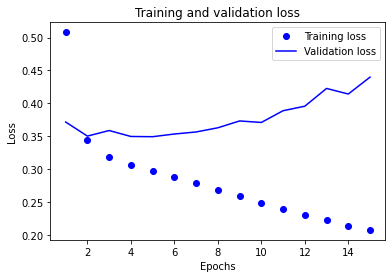

In [13]:
# Loss, Accuracy 그래프 시각화
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

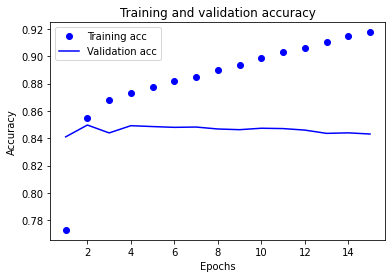

In [14]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [15]:
# 학습된 Embedding 레이어 분석
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [16]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
import os
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [17]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([ 0.01209878,  0.12193312, -0.02532627,  0.12591591,  0.04210785,
        0.00894265, -0.0743772 , -0.01753911, -0.08413924, -0.0213413 ,
       -0.05255919, -0.00525878,  0.03626252,  0.02232199, -0.0268458 ,
        0.0244294 ], dtype=float32)

In [18]:
word_vectors.similar_by_word("재미")

[('넘', 0.8205456733703613),
 ('클라스', 0.8111249804496765),
 ('너무나', 0.8091899752616882),
 ('어스', 0.8037257194519043),
 ('특색', 0.801766574382782),
 ('너무', 0.7987340092658997),
 ('지극히', 0.7942426800727844),
 ('완전', 0.7822526693344116),
 ('이렇게', 0.7803407311439514),
 ('타리', 0.7735151648521423)]

### 1-D Convolution Neural Network(1-D CNN) 모델

In [19]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [20]:
# validation set 40000건 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(106182, 41)
(106182,)


In [21]:
# 모델 훈련
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
208/208 [==============================] - 14s 7ms/step - loss: 0.5010 - accuracy: 0.7518 - val_loss: 0.3606 - val_accuracy: 0.8437
Epoch 2/15
208/208 [==============================] - 1s 5ms/step - loss: 0.3313 - accuracy: 0.8590 - val_loss: 0.3438 - val_accuracy: 0.8515
Epoch 3/15
208/208 [==============================] - 1s 5ms/step - loss: 0.2961 - accuracy: 0.8765 - val_loss: 0.3461 - val_accuracy: 0.8520
Epoch 4/15
208/208 [==============================] - 1s 5ms/step - loss: 0.2686 - accuracy: 0.8902 - val_loss: 0.3481 - val_accuracy: 0.8525
Epoch 5/15
208/208 [==============================] - 1s 5ms/step - loss: 0.2397 - accuracy: 0.9047 - val_loss: 0.3648 - val_accuracy: 0.8510
Epoch 6/15
208/208 [==============================] - 1s 5ms/step - loss: 0.2091 - accuracy: 0.9199 - val_loss: 0.3827 - val_accuracy: 0.8456
Epoch 7/15
208/208 [==============================] - 1s 5ms/step - loss: 0.1748 - accuracy: 0.9360 - val_loss: 0.4171 - val_accuracy: 0.8421
Epoch

In [22]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8651 - accuracy: 0.8177
[0.8651334047317505, 0.8177268505096436]


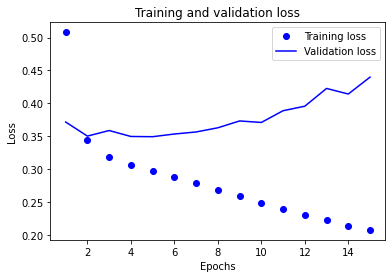

In [23]:
# Loss, Accuracy 그래프 시각화
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

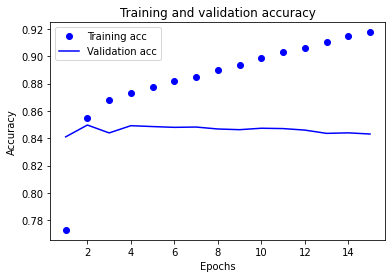

In [24]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [25]:
# 학습된 Embedding 레이어 분석
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [26]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([-0.18082795, -0.04292393,  0.06724203,  0.053313  ,  0.04171894,
       -0.04894951,  0.04847364,  0.06057163,  0.13998435,  0.11369449,
       -0.06780887, -0.02345042,  0.06046154,  0.03370677,  0.02593365,
        0.00856256], dtype=float32)

In [28]:
word_vectors.similar_by_word("재미")

[('ㄴ', 0.8456705212593079),
 ('아아아', 0.8402509689331055),
 ('젤', 0.8239538669586182),
 ('글로리아', 0.81868976354599),
 ('진', 0.8174690008163452),
 ('설렘', 0.8135358095169067),
 ('럽', 0.7990531325340271),
 ('땡기', 0.7955758571624756),
 ('정말', 0.7859002351760864),
 ('으로부터', 0.784127950668335)]

### GlobalMaxPooling1D( ) 모델

In [29]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [30]:
# validation set 40000건 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(106182, 41)
(106182,)


In [31]:
# 모델 훈련
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
208/208 [==============================] - 1s 4ms/step - loss: 0.6257 - accuracy: 0.6941 - val_loss: 0.5047 - val_accuracy: 0.8058
Epoch 2/15
208/208 [==============================] - 1s 4ms/step - loss: 0.4156 - accuracy: 0.8319 - val_loss: 0.3763 - val_accuracy: 0.8346
Epoch 3/15
208/208 [==============================] - 1s 4ms/step - loss: 0.3420 - accuracy: 0.8553 - val_loss: 0.3578 - val_accuracy: 0.8425
Epoch 4/15
208/208 [==============================] - 1s 4ms/step - loss: 0.3112 - accuracy: 0.8700 - val_loss: 0.3547 - val_accuracy: 0.8446
Epoch 5/15
208/208 [==============================] - 1s 4ms/step - loss: 0.2898 - accuracy: 0.8801 - val_loss: 0.3566 - val_accuracy: 0.8457
Epoch 6/15
208/208 [==============================] - 1s 4ms/step - loss: 0.2726 - accuracy: 0.8880 - val_loss: 0.3616 - val_accuracy: 0.8452
Epoch 7/15
208/208 [==============================] - 1s 4ms/step - loss: 0.2580 - accuracy: 0.8963 - val_loss: 0.3690 - val_accuracy: 0.8438
Epoch 

In [32]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4611 - accuracy: 0.8288
[0.4611019492149353, 0.828793466091156]


In [33]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


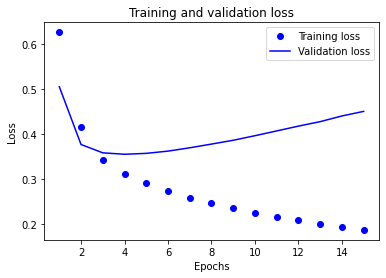

In [34]:
# Loss, Accuracy 그래프 시각화
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

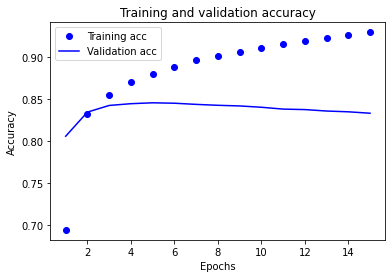

In [35]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [36]:
# 학습된 Embedding 레이어 분석
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [37]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [38]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([ 0.07908712, -0.0380395 , -0.15704095,  0.10317864, -0.16499044,
       -0.08582383, -0.25075218, -0.00269826, -0.1419763 , -0.12626164,
       -0.05226258, -0.1771697 , -0.13566138, -0.16474389, -0.10110728,
       -0.01804196], dtype=float32)

In [39]:
word_vectors.similar_by_word("재미")

[('남', 0.9168239831924438),
 ('느껴질', 0.9022979140281677),
 ('열라', 0.8892644643783569),
 ('팍팍', 0.8771398663520813),
 ('확', 0.8722415566444397),
 ('간', 0.865526556968689),
 ('오정세', 0.8654088973999023),
 ('알', 0.8613619208335876),
 ('힛', 0.8607901930809021),
 ('전', 0.8605979084968567)]

한국어 Word2Vec 임베딩 활용하여 성능 개선

In [40]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word2vec.wv['재미']

In [41]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.wv.similar_by_word("재미")

[('묘미', 0.6163142919540405),
 ('취미', 0.6034970283508301),
 ('흥미', 0.5939850211143494),
 ('유머', 0.5888698101043701),
 ('보람', 0.5689517259597778),
 ('즐거움', 0.5631207823753357),
 ('개그', 0.5552946329116821),
 ('이야기', 0.5536993741989136),
 ('연애', 0.552293598651886),
 ('열의', 0.546456515789032)]

In [42]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [43]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,118,289
Trainable params: 1,118,289
Non-trainable params: 0
_________________________________________________________________


In [44]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
415/415 [==============================] - 5s 8ms/step - loss: 0.4537 - accuracy: 0.7846 - val_loss: 0.3750 - val_accuracy: 0.8334
Epoch 2/10
415/415 [==============================] - 3s 7ms/step - loss: 0.3363 - accuracy: 0.8519 - val_loss: 0.3366 - val_accuracy: 0.8506
Epoch 3/10
415/415 [==============================] - 3s 7ms/step - loss: 0.2887 - accuracy: 0.8766 - val_loss: 0.3228 - val_accuracy: 0.8601
Epoch 4/10
415/415 [==============================] - 3s 7ms/step - loss: 0.2553 - accuracy: 0.8937 - val_loss: 0.3200 - val_accuracy: 0.8630
Epoch 5/10
415/415 [==============================] - 3s 7ms/step - loss: 0.2262 - accuracy: 0.9072 - val_loss: 0.3320 - val_accuracy: 0.8626
Epoch 6/10
415/415 [==============================] - 3s 7ms/step - loss: 0.1984 - accuracy: 0.9204 - val_loss: 0.3496 - val_accuracy: 0.8606
Epoch 7/10
415/415 [==============================] - 3s 7ms/step - loss: 0.1679 - accuracy: 0.9341 - val_loss: 0.3768 - val_accuracy: 0.8604
Epoch 

In [45]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5067 - accuracy: 0.8500
[0.5066809058189392, 0.8499501347541809]


### 진행 과정

   - 데이터 불러오기
   - 데이터 전처리 및 train, test 데이터 분리
   - 모델 학습
        - RNN 모델 -> 정확도 = 0.8394 
        - CNN(1-D CNN) 모델 -> 정확도 = 0.8187
        - GlobalMaxPooling1D( ) 모델 -> 정확도 = 0.8289
        - 정확도만 보면 나쁘지 않다 생각할 수 있지만 유사한 단어와 그 유사도를 확인하면 딱히 유사한 단어를 찾지 못하는 걸 볼 수 있다
   - 한국어 Word2Vec 임베딩 활용하여 성능 개선
        - 한국어 Word2Vec를 활용하여 단어 유사도를 확인해보니 꽤 유사한 단어를 찾아내는 것을 확인 가능
        - 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습
        - CNN 모델로 도전 
        - batch size를 32, 64, 128, 256, 1024, 2048, 4096으로 시도 -> 정확도가 최대 0.8350
        - RNN 모델로 도전
        - LSTM state 벡터의 차원수 = 8, batch size = 64, 128으로 시도 -> 정확도 최대 0.8388
        .
        .
        .
        - LSTM state 벡터의 차원수 = 64, batch size = 32, 64, 128으로 시도 -> 0.8442
        - LSTM state 벡터의 차원수 = 128, batch size = 32, 64, 128, 256으로 시도 -> 0.85

### 회고
    - 처음에 코랩으로 시도했으나 여러 에러 때문에 고생을 함..
    - 한국어 Word2Vec을 활용하여 정확도를 85% 이상 달성하기 위해 처음엔 batch size만 바꿈 -> 실패
    - LSTM state 벡터의 차원수도 바꿔가며 재시도 -> 성공
    - RNN 모델으로 정확도 0.85이상을 도달했기 때문에 딱히 GlobalMaxPooling1D( ) 모델는 시도 x